In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from prophet import Prophet
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Metro_homes.csv to Metro_homes.csv


In [4]:
df_homes_forecast = pd.read_csv("Metro_homes.csv")
df_homes_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416926 entries, 0 to 416925
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   period_begin                    416926 non-null  object 
 1   period_end                      416926 non-null  object 
 2   parent_metro_region_metro_code  416926 non-null  int64  
 3   parent_metro_region             416926 non-null  object 
 4   state_code                      416926 non-null  object 
 5   property_type_id                416926 non-null  int64  
 6   property_type                   416926 non-null  object 
 7   median_sale_price               416382 non-null  float64
 8   median_list_price               388970 non-null  float64
 9   median_ppsf                     412248 non-null  float64
 10  median_list_ppsf                386245 non-null  float64
 11  homes_sold                      416386 non-null  float64
 12  pending_sales   

In [5]:
df_homes_forecast['period_end'] = pd.to_datetime(df_homes_forecast['period_end'])
df_homes_forecast['period_begin'] = pd.to_datetime(df_homes_forecast['period_begin'])
df_homes_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416926 entries, 0 to 416925
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   period_begin                    416926 non-null  datetime64[ns]
 1   period_end                      416926 non-null  datetime64[ns]
 2   parent_metro_region_metro_code  416926 non-null  int64         
 3   parent_metro_region             416926 non-null  object        
 4   state_code                      416926 non-null  object        
 5   property_type_id                416926 non-null  int64         
 6   property_type                   416926 non-null  object        
 7   median_sale_price               416382 non-null  float64       
 8   median_list_price               388970 non-null  float64       
 9   median_ppsf                     412248 non-null  float64       
 10  median_list_ppsf                386245 non-null  float64

In [7]:
df_homes_colab = df_homes_forecast.loc[df_homes_forecast['property_type'] != 'All Residential']
df_homes_colab
# sfr_df=df_homes_forecast['period_begin ',],

,period_begin,period_end,parent_metro_region_metro_code,parent_metro_region,state_code,property_type_id,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,price_drops
0,2016-07-01,2016-07-31,15660,"Calhoun, GA",GA,13,Townhouse,166900.0,122900.0,95.535203,79.339451,2.0,NaN,2.0,6.0,3.0,133.0,0.166667
1,2022-08-01,2022-08-31,33740,"Monroe, LA",LA,6,Single Family Residential,210000.0,215000.0,117.937595,113.065034,156.0,125.0,148.0,312.0,2.0,20.0,0.362179
2,2020-02-01,2020-02-29,39740,"Reading, PA",PA,4,Multi-Family (2-4 Unit),103250.0,129900.0,49.502539,56.662269,10.0,12.0,27.0,69.0,6.9,63.0,0.115942
3,2018-07-01,2018-07-31,37460,"Panama City, FL",FL,13,Townhouse,174700.0,196500.0,124.080882,137.240526,25.0,20.0,53.0,156.0,6.2,94.0,NaN
4,2020-09-01,2020-09-30,15420,"Burley, ID",ID,6,Single Family Residential,207250.0,207500.0,122.710623,129.365592,40.0,23.0,32.0,103.0,2.6,84.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416920,2021-08-01,2021-08-31,43740,"Somerset, PA",PA,3,Condo/Co-op,276000.0,327000.0,215.527025,231.182796,6.0,4.0,2.0,9.0,1.5,75.0,0.222222
416922,2018-10-01,2018-10-31,28140,"Kansas City, MO",MO,4,Multi-Family (2-4 Unit),170000.0,160000.0,52.623458,68.717277,51.0,NaN,72.0,NaN,2.4,34.0,0.130081
416923,2018-05-01,2018-05-31,20100,"Dover, DE",DE,13,Townhouse,177750.0,180000.0,103.021978,97.267980,24.0,19.0,42.0,89.0,3.7,39.0,0.269663
416924,2017-10-01,2017-10-31,23844,"Gary, IN",IN,13,Townhouse,161389.0,168260.0,110.892857,109.829060,77.0,47.0,99.0,353.0,4.6,73.0,NaN


<Axes: xlabel='ds'>

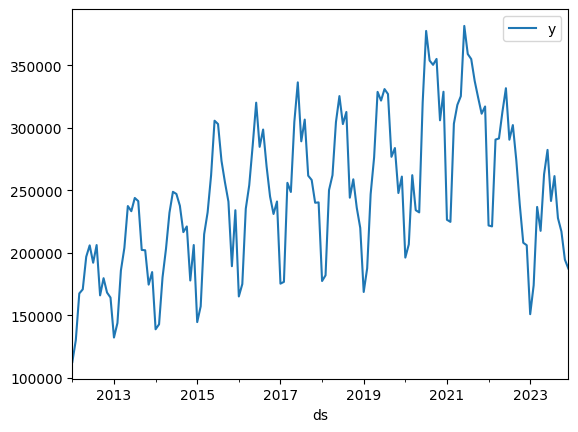

In [19]:
df_homes_srf = df_homes_forecast.loc[df_homes_forecast['property_type'] == 'Single Family Residential']
df_homes_srf1 = df_homes_srf[['period_begin','homes_sold']].rename(columns={'period_begin':'ds','homes_sold':'y'}).sort_values(by='ds').dropna()
df_homes_srf_sum=df_homes_srf1.groupby('ds')['y'].agg(['sum']).rename(columns={'sum':'y'})
df_homes_srf_sum.plot()

In [20]:
prophet_srf=df_homes_srf_sum.reset_index()
prophet_srf

,ds,y
0,2012-01-01,112719.0
1,2012-02-01,130198.0
2,2012-03-01,167492.0
3,2012-04-01,170803.0
4,2012-05-01,196881.0
...,...,...
139,2023-08-01,261437.0
140,2023-09-01,227835.0
141,2023-10-01,217136.0
142,2023-11-01,194587.0


In [22]:
m1 = Prophet()
m1.fit(prophet_srf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4cior0x/x0mgji7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4cior0x/zj7w4qbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78396', 'data', 'file=/tmp/tmpj4cior0x/x0mgji7a.json', 'init=/tmp/tmpj4cior0x/zj7w4qbg.json', 'output', 'file=/tmp/tmpj4cior0x/prophet_model9wpyk1uq/prophet_model-20240209023858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:38:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
future_srf = m1.make_future_dataframe(periods=12, freq='M')
future_srf

,ds
0,2012-01-01
1,2012-02-01
2,2012-03-01
3,2012-04-01
4,2012-05-01
...,...
151,2024-07-31
152,2024-08-31
153,2024-09-30
154,2024-10-31


In [25]:
forecast_srf = m1.predict(future_srf)
forecast_srf

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,175214.788624,74139.315996,125696.619144,175214.788624,175214.788624,-74953.907349,-74953.907349,-74953.907349,-74953.907349,-74953.907349,-74953.907349,0.0,0.0,0.0,100260.881275
1,2012-02-01,176484.596660,86061.751498,136407.195870,176484.596660,176484.596660,-65317.057321,-65317.057321,-65317.057321,-65317.057321,-65317.057321,-65317.057321,0.0,0.0,0.0,111167.539339
2,2012-03-01,177672.481598,145893.733774,200350.962313,177672.481598,177672.481598,-4749.041545,-4749.041545,-4749.041545,-4749.041545,-4749.041545,-4749.041545,0.0,0.0,0.0,172923.440053
3,2012-04-01,178942.289634,152629.721197,204827.742024,178942.289634,178942.289634,-24.831697,-24.831697,-24.831697,-24.831697,-24.831697,-24.831697,0.0,0.0,0.0,178917.457937
4,2012-05-01,180171.136121,174773.490570,225534.621296,180171.136121,180171.136121,20953.231136,20953.231136,20953.231136,20953.231136,20953.231136,20953.231136,0.0,0.0,0.0,201124.367257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2024-07-31,201032.498748,217194.862900,269371.098724,199689.649466,202183.769119,42828.128937,42828.128937,42828.128937,42828.128937,42828.128937,42828.128937,0.0,0.0,0.0,243860.627686
152,2024-08-31,198414.465071,183064.113762,234479.785129,196717.306292,199861.189805,11285.789074,11285.789074,11285.789074,11285.789074,11285.789074,11285.789074,0.0,0.0,0.0,209700.254145
153,2024-09-30,195880.884093,179234.036564,230413.223974,193884.380834,197678.301377,9364.110510,9364.110510,9364.110510,9364.110510,9364.110510,9364.110510,0.0,0.0,0.0,205244.994603
154,2024-10-31,193262.850416,140784.339119,192575.897598,190962.842408,195425.979541,-27891.804362,-27891.804362,-27891.804362,-27891.804362,-27891.804362,-27891.804362,0.0,0.0,0.0,165371.046053


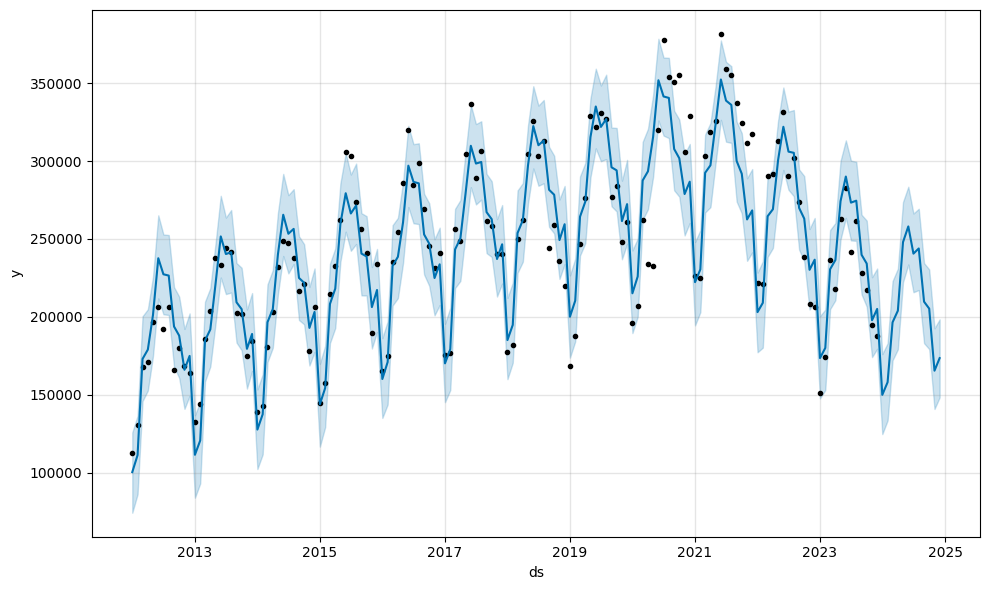

In [26]:
m1.plot(forecast_srf);

In [27]:
forecast_srf[['ds','yhat','yhat_lower','yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2012-01-01,100260.881275,74139.315996,125696.619144
1,2012-02-01,111167.539339,86061.751498,136407.195870
2,2012-03-01,172923.440053,145893.733774,200350.962313
3,2012-04-01,178917.457937,152629.721197,204827.742024
4,2012-05-01,201124.367257,174773.490570,225534.621296
...,...,...,...,...
151,2024-07-31,243860.627686,217194.862900,269371.098724
152,2024-08-31,209700.254145,183064.113762,234479.785129
153,2024-09-30,205244.994603,179234.036564,230413.223974
154,2024-10-31,165371.046053,140784.339119,192575.897598


In [29]:
forecast_srf=forecast_srf.set_index('ds')


KeyError: "None of ['ds'] are in the columns"

In [30]:
forecast_srf

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2012-01-01,175214.788624,74139.315996,125696.619144,175214.788624,175214.788624,-74953.907349,-74953.907349,-74953.907349,-74953.907349,-74953.907349,-74953.907349,0.0,0.0,0.0,100260.881275
2012-02-01,176484.596660,86061.751498,136407.195870,176484.596660,176484.596660,-65317.057321,-65317.057321,-65317.057321,-65317.057321,-65317.057321,-65317.057321,0.0,0.0,0.0,111167.539339
2012-03-01,177672.481598,145893.733774,200350.962313,177672.481598,177672.481598,-4749.041545,-4749.041545,-4749.041545,-4749.041545,-4749.041545,-4749.041545,0.0,0.0,0.0,172923.440053
2012-04-01,178942.289634,152629.721197,204827.742024,178942.289634,178942.289634,-24.831697,-24.831697,-24.831697,-24.831697,-24.831697,-24.831697,0.0,0.0,0.0,178917.457937
2012-05-01,180171.136121,174773.490570,225534.621296,180171.136121,180171.136121,20953.231136,20953.231136,20953.231136,20953.231136,20953.231136,20953.231136,0.0,0.0,0.0,201124.367257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,201032.498748,217194.862900,269371.098724,199689.649466,202183.769119,42828.128937,42828.128937,42828.128937,42828.128937,42828.128937,42828.128937,0.0,0.0,0.0,243860.627686
2024-08-31,198414.465071,183064.113762,234479.785129,196717.306292,199861.189805,11285.789074,11285.789074,11285.789074,11285.789074,11285.789074,11285.789074,0.0,0.0,0.0,209700.254145
2024-09-30,195880.884093,179234.036564,230413.223974,193884.380834,197678.301377,9364.110510,9364.110510,9364.110510,9364.110510,9364.110510,9364.110510,0.0,0.0,0.0,205244.994603


<Axes: xlabel='ds'>

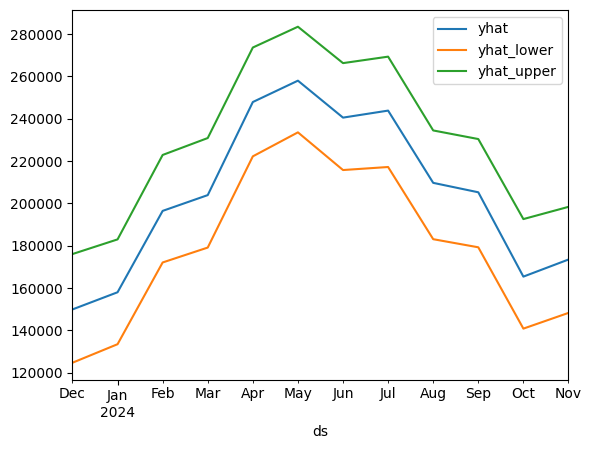

In [31]:
forecast_srf[['yhat','yhat_lower','yhat_upper']].iloc[-12:,:].plot()

In [32]:
forecast_srf = forecast_srf.reset_index()
forecast_srf

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,175214.788624,74139.315996,125696.619144,175214.788624,175214.788624,-74953.907349,-74953.907349,-74953.907349,-74953.907349,-74953.907349,-74953.907349,0.0,0.0,0.0,100260.881275
1,2012-02-01,176484.596660,86061.751498,136407.195870,176484.596660,176484.596660,-65317.057321,-65317.057321,-65317.057321,-65317.057321,-65317.057321,-65317.057321,0.0,0.0,0.0,111167.539339
2,2012-03-01,177672.481598,145893.733774,200350.962313,177672.481598,177672.481598,-4749.041545,-4749.041545,-4749.041545,-4749.041545,-4749.041545,-4749.041545,0.0,0.0,0.0,172923.440053
3,2012-04-01,178942.289634,152629.721197,204827.742024,178942.289634,178942.289634,-24.831697,-24.831697,-24.831697,-24.831697,-24.831697,-24.831697,0.0,0.0,0.0,178917.457937
4,2012-05-01,180171.136121,174773.490570,225534.621296,180171.136121,180171.136121,20953.231136,20953.231136,20953.231136,20953.231136,20953.231136,20953.231136,0.0,0.0,0.0,201124.367257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2024-07-31,201032.498748,217194.862900,269371.098724,199689.649466,202183.769119,42828.128937,42828.128937,42828.128937,42828.128937,42828.128937,42828.128937,0.0,0.0,0.0,243860.627686
152,2024-08-31,198414.465071,183064.113762,234479.785129,196717.306292,199861.189805,11285.789074,11285.789074,11285.789074,11285.789074,11285.789074,11285.789074,0.0,0.0,0.0,209700.254145
153,2024-09-30,195880.884093,179234.036564,230413.223974,193884.380834,197678.301377,9364.110510,9364.110510,9364.110510,9364.110510,9364.110510,9364.110510,0.0,0.0,0.0,205244.994603
154,2024-10-31,193262.850416,140784.339119,192575.897598,190962.842408,195425.979541,-27891.804362,-27891.804362,-27891.804362,-27891.804362,-27891.804362,-27891.804362,0.0,0.0,0.0,165371.046053


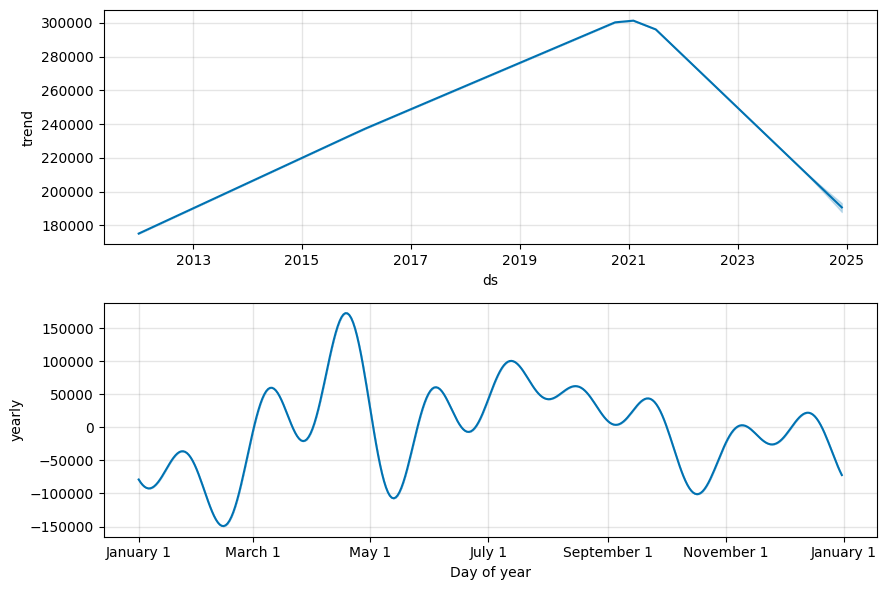

In [33]:
fig1=m1.plot_components(forecast_srf)

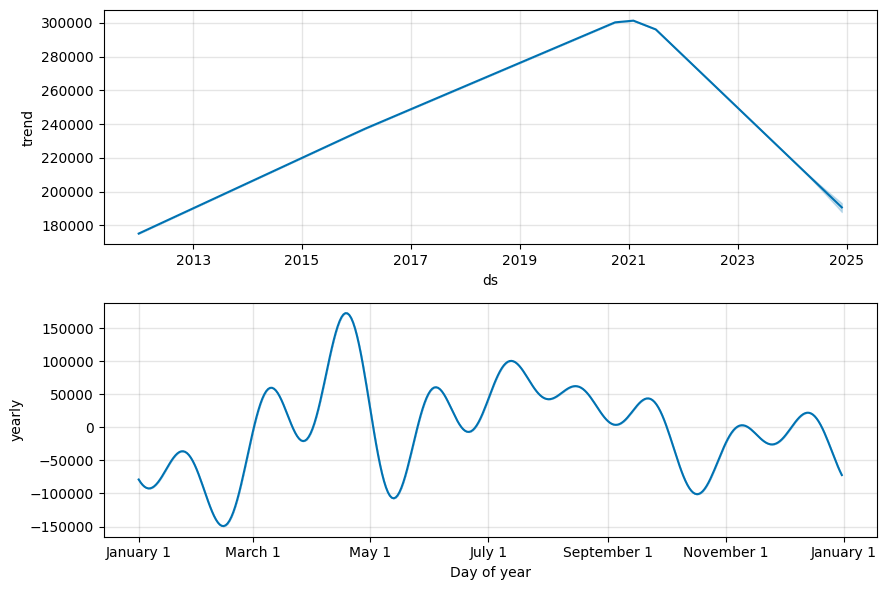

In [34]:
fig2=m1.plot_components(forecast_srf)